In [1]:
import time
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from qiskit.primitives import Sampler
from qiskit.circuit.library import ZFeatureMap
from qiskit_algorithms.optimizers import COBYLA

from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import VQC

algorithm_globals.random_seed = 57

In [2]:
# read the dataset from the file
df = pd.read_csv("final_dataset.csv")

features, labels = df.iloc[:, :-1], df.iloc[:, [-1]]
# features = MinMaxScaler().fit_transform(features)
labels = labels.to_numpy().ravel()

In [3]:
features = PCA(n_components=3).fit_transform(features)

In [4]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [5]:
num_features = features.shape[1]
feature_map = ZFeatureMap(feature_dimension=num_features, reps=3)
ansatz = RealAmplitudes(num_qubits=num_features, reps=5, entanglement="full")
optimizer = COBYLA(maxiter=20)

sampler = Sampler()

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [6]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
    num_qubits=num_features,
    loss="cross_entropy",
)

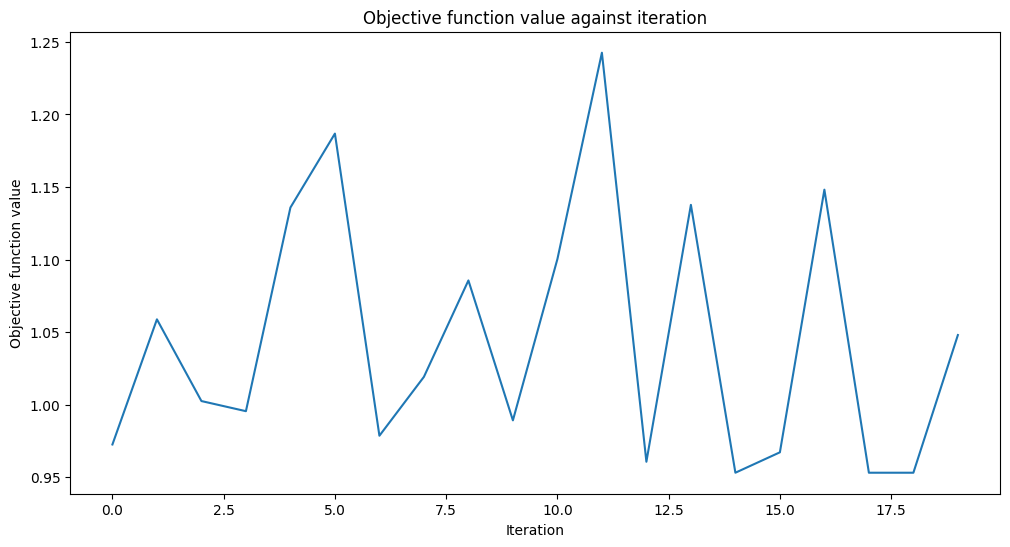

In [7]:
# clear objective value history
objective_func_vals = []
vqc.fit(train_features, train_labels)

In [8]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.63
Quantum VQC on the test dataset:     0.62


In [9]:
vqc.save("v3.model")